# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 預防錯誤： OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape:int, output_units=10):
    """
    使用兩層隱藏層，一個輸出層(softmax)
    """
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.Dense(units=128, activation="relu", name="hidden_layer_0")(input_layer)
    x = keras.layers.Dense(units=64, activation="relu", name="hidden_layer_1")(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATES = [0.1, 0.01, 0.001, 0.0001]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
NESTEROV = True  
DECAY = 0.01

In [7]:
# 定義不同的optimazer
def make_optimizer(name: str, lr: float):
    if name == 'sgd':
        return keras.optimizers.SGD(lr=lr, nesterov=NESTEROV, momentum=MOMENTUM)
    elif name == 'adam':
        return keras.optimizers.Adam(lr=lr)
    elif name =='rmsprop':
        return keras.optimizers.RMSprop(lr=lr, epsilon=None, decay=DECAY) 
    else:    
        # adagrad
        return keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=DECAY)


In [8]:
results = {}
"""
以 learning_rate & optimizer 跑兩層迴圈
"""
for lr in LEARNING_RATES:
    for name in ['sgd','adam','rmsprop','adagrad']:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with optimizer = {}, learning_rate={}".format(name, str(lr)))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = make_optimizer(name, lr)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-{}-{}".format(name, str(lr))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with optimizer = sgd, learning_rate=0.1
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 128)               393344    
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 402,250
Trainable params: 402,250
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=======================

50000/50000 [==============================] - 4s 90us/step - loss: 2.3039 - acc: 0.0980 - val_loss: 2.3033 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 4s 90us/step - loss: 2.3042 - acc: 0.0990 - val_loss: 2.3030 - val_acc: 0.1000
Experiment with optimizer = adam, learning_rate=0.1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 128)               393344    
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 402,250
Trainable params: 402,250
Non-trainable params: 0
__________________

50000/50000 [==============================] - 7s 130us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Experiment with optimizer = rmsprop, learning_rate=0.1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 128)               393344    
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 402,250
Trainable params: 402,250
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==========

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 121us/step - loss: 14.4477 - acc: 0.0998 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/50
50000/50000 [==============================] - 5s 100us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 5s 99us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 5s 98us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 5s 98us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 5s 98us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 5s 98us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 1

50000/50000 [==============================] - 4s 82us/step - loss: 1.6283 - acc: 0.4254 - val_loss: 1.5848 - val_acc: 0.4370
Epoch 3/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.5469 - acc: 0.4511 - val_loss: 1.5520 - val_acc: 0.4496
Epoch 4/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.4906 - acc: 0.4727 - val_loss: 1.4938 - val_acc: 0.4650
Epoch 5/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.4498 - acc: 0.4875 - val_loss: 1.4972 - val_acc: 0.4731
Epoch 6/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.4122 - acc: 0.4998 - val_loss: 1.5101 - val_acc: 0.4622
Epoch 7/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.3828 - acc: 0.5098 - val_loss: 1.4581 - val_acc: 0.4763
Epoch 8/50
50000/50000 [==============================] - 5s 96us/step - loss: 1.3605 - acc: 0.5166 - val_loss: 1.4240 - val_acc: 0.4942
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 6s 124us/step - loss: 1.7495 - acc: 0.3707 - val_loss: 1.7349 - val_acc: 0.3814
Epoch 5/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.7148 - acc: 0.3851 - val_loss: 1.6706 - val_acc: 0.4055
Epoch 6/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.6877 - acc: 0.3925 - val_loss: 1.6747 - val_acc: 0.3982
Epoch 7/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.6653 - acc: 0.4009 - val_loss: 1.6376 - val_acc: 0.4138
Epoch 8/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.6519 - acc: 0.4070 - val_loss: 1.6714 - val_acc: 0.4071
Epoch 9/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.6426 - acc: 0.4082 - val_loss: 1.6179 - val_acc: 0.4223
Epoch 10/50
50000/50000 [==============================] - 7s 138us/step - loss: 1.6351 - acc: 0.4142 - val_loss: 1.6918 - val_acc: 0.3890
Epoch 11/50
50000/50000 [===================

50000/50000 [==============================] - 5s 108us/step - loss: 1.6794 - acc: 0.3995 - val_loss: 1.6920 - val_acc: 0.3867
Epoch 7/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.6439 - acc: 0.4112 - val_loss: 1.6528 - val_acc: 0.4065
Epoch 8/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.6166 - acc: 0.4245 - val_loss: 1.6665 - val_acc: 0.4019
Epoch 9/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.5932 - acc: 0.4334 - val_loss: 1.6093 - val_acc: 0.4219
Epoch 10/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.5739 - acc: 0.4408 - val_loss: 1.5831 - val_acc: 0.4350
Epoch 11/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.5600 - acc: 0.4460 - val_loss: 1.6460 - val_acc: 0.4159
Epoch 12/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.5460 - acc: 0.4535 - val_loss: 1.5802 - val_acc: 0.4349
Epoch 13/50
50000/50000 [=================

50000/50000 [==============================] - 6s 119us/step - loss: 1.8411 - acc: 0.3580 - val_loss: 1.8394 - val_acc: 0.3521
Epoch 9/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.8368 - acc: 0.3585 - val_loss: 1.8358 - val_acc: 0.3551
Epoch 10/50
50000/50000 [==============================] - 6s 118us/step - loss: 1.8332 - acc: 0.3606 - val_loss: 1.8319 - val_acc: 0.3563
Epoch 11/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.8299 - acc: 0.3626 - val_loss: 1.8293 - val_acc: 0.3546
Epoch 12/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.8273 - acc: 0.3627 - val_loss: 1.8271 - val_acc: 0.3573
Epoch 13/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.8249 - acc: 0.3636 - val_loss: 1.8250 - val_acc: 0.3587
Epoch 14/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.8228 - acc: 0.3644 - val_loss: 1.8227 - val_acc: 0.3591
Epoch 15/50
50000/50000 [===============

50000/50000 [==============================] - 4s 88us/step - loss: 1.5801 - acc: 0.4471 - val_loss: 1.5810 - val_acc: 0.4464
Epoch 11/50
50000/50000 [==============================] - 4s 90us/step - loss: 1.5604 - acc: 0.4532 - val_loss: 1.5667 - val_acc: 0.4506
Epoch 12/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.5421 - acc: 0.4583 - val_loss: 1.5576 - val_acc: 0.4520
Epoch 13/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.5245 - acc: 0.4645 - val_loss: 1.5341 - val_acc: 0.4620
Epoch 14/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.5083 - acc: 0.4727 - val_loss: 1.5332 - val_acc: 0.4610
Epoch 15/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.4939 - acc: 0.4760 - val_loss: 1.5225 - val_acc: 0.4644
Epoch 16/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.4776 - acc: 0.4800 - val_loss: 1.4993 - val_acc: 0.4753
Epoch 17/50
50000/50000 [=====================

50000/50000 [==============================] - 6s 122us/step - loss: 1.4534 - acc: 0.4844 - val_loss: 1.5074 - val_acc: 0.4636
Epoch 13/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.4455 - acc: 0.4879 - val_loss: 1.4775 - val_acc: 0.4754
Epoch 14/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.4237 - acc: 0.4953 - val_loss: 1.4534 - val_acc: 0.4892
Epoch 15/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.4183 - acc: 0.4952 - val_loss: 1.4695 - val_acc: 0.4798
Epoch 16/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.4082 - acc: 0.4984 - val_loss: 1.4712 - val_acc: 0.4800
Epoch 17/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.3895 - acc: 0.5078 - val_loss: 1.4462 - val_acc: 0.4862
Epoch 18/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.3854 - acc: 0.5072 - val_loss: 1.4734 - val_acc: 0.4862
Epoch 19/50
50000/50000 [==============

50000/50000 [==============================] - 6s 113us/step - loss: 1.6333 - acc: 0.4296 - val_loss: 1.6416 - val_acc: 0.4238
Epoch 15/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.6289 - acc: 0.4299 - val_loss: 1.6377 - val_acc: 0.4262
Epoch 16/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.6251 - acc: 0.4309 - val_loss: 1.6387 - val_acc: 0.4248
Epoch 17/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.6209 - acc: 0.4342 - val_loss: 1.6357 - val_acc: 0.4274
Epoch 18/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.6177 - acc: 0.4347 - val_loss: 1.6277 - val_acc: 0.4329
Epoch 19/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.6140 - acc: 0.4354 - val_loss: 1.6270 - val_acc: 0.4296
Epoch 20/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.6113 - acc: 0.4365 - val_loss: 1.6235 - val_acc: 0.4286
Epoch 21/50
50000/50000 [==============

50000/50000 [==============================] - 5s 107us/step - loss: 1.8698 - acc: 0.3473 - val_loss: 1.8726 - val_acc: 0.3413
Epoch 17/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.8690 - acc: 0.3479 - val_loss: 1.8719 - val_acc: 0.3413
Epoch 18/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.8684 - acc: 0.3479 - val_loss: 1.8713 - val_acc: 0.3415
Epoch 19/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.8678 - acc: 0.3476 - val_loss: 1.8706 - val_acc: 0.3421
Epoch 20/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.8672 - acc: 0.3485 - val_loss: 1.8700 - val_acc: 0.3426
Epoch 21/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.8666 - acc: 0.3486 - val_loss: 1.8695 - val_acc: 0.3416
Epoch 22/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.8662 - acc: 0.3489 - val_loss: 1.8690 - val_acc: 0.3423
Epoch 23/50
50000/50000 [==============

50000/50000 [==============================] - 4s 85us/step - loss: 1.8023 - acc: 0.3720 - val_loss: 1.8036 - val_acc: 0.3714
Epoch 19/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.7948 - acc: 0.3733 - val_loss: 1.7966 - val_acc: 0.3760
Epoch 20/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.7882 - acc: 0.3773 - val_loss: 1.7927 - val_acc: 0.3752
Epoch 21/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.7817 - acc: 0.3787 - val_loss: 1.7834 - val_acc: 0.3798
Epoch 22/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.7754 - acc: 0.3800 - val_loss: 1.7789 - val_acc: 0.3821
Epoch 23/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.7694 - acc: 0.3837 - val_loss: 1.7725 - val_acc: 0.3819
Epoch 24/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.7635 - acc: 0.3847 - val_loss: 1.7665 - val_acc: 0.3836
Epoch 25/50
50000/50000 [=====================

50000/50000 [==============================] - 5s 109us/step - loss: 1.4021 - acc: 0.5084 - val_loss: 1.4484 - val_acc: 0.4892
Epoch 21/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.3870 - acc: 0.5157 - val_loss: 1.4562 - val_acc: 0.4847
Epoch 22/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.3793 - acc: 0.5172 - val_loss: 1.4461 - val_acc: 0.4923
Epoch 23/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.3711 - acc: 0.5205 - val_loss: 1.4322 - val_acc: 0.4913
Epoch 24/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.3636 - acc: 0.5239 - val_loss: 1.4268 - val_acc: 0.4968
Epoch 25/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.3545 - acc: 0.5250 - val_loss: 1.4271 - val_acc: 0.4968
Epoch 26/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.3490 - acc: 0.5274 - val_loss: 1.4184 - val_acc: 0.5003
Epoch 27/50
50000/50000 [==============

50000/50000 [==============================] - 5s 106us/step - loss: 1.7342 - acc: 0.3961 - val_loss: 1.7415 - val_acc: 0.3928
Epoch 23/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.7323 - acc: 0.3969 - val_loss: 1.7400 - val_acc: 0.3925
Epoch 24/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.7306 - acc: 0.3975 - val_loss: 1.7380 - val_acc: 0.3929
Epoch 25/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.7289 - acc: 0.3988 - val_loss: 1.7365 - val_acc: 0.3926
Epoch 26/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.7274 - acc: 0.4004 - val_loss: 1.7352 - val_acc: 0.3938
Epoch 27/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.7259 - acc: 0.3995 - val_loss: 1.7338 - val_acc: 0.3950
Epoch 28/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.7245 - acc: 0.3999 - val_loss: 1.7326 - val_acc: 0.3963
Epoch 29/50
50000/50000 [==============

50000/50000 [==============================] - 5s 96us/step - loss: 2.1071 - acc: 0.2566 - val_loss: 2.1077 - val_acc: 0.2563
Epoch 25/50
50000/50000 [==============================] - 5s 96us/step - loss: 2.1068 - acc: 0.2567 - val_loss: 2.1075 - val_acc: 0.2561
Epoch 26/50
50000/50000 [==============================] - 5s 96us/step - loss: 2.1065 - acc: 0.2569 - val_loss: 2.1072 - val_acc: 0.2559
Epoch 27/50
50000/50000 [==============================] - 5s 96us/step - loss: 2.1062 - acc: 0.2568 - val_loss: 2.1069 - val_acc: 0.2560
Epoch 28/50
50000/50000 [==============================] - 5s 95us/step - loss: 2.1060 - acc: 0.2569 - val_loss: 2.1067 - val_acc: 0.2562
Epoch 29/50
50000/50000 [==============================] - 5s 96us/step - loss: 2.1057 - acc: 0.2571 - val_loss: 2.1065 - val_acc: 0.2561
Epoch 30/50
50000/50000 [==============================] - 5s 95us/step - loss: 2.1055 - acc: 0.2572 - val_loss: 2.1063 - val_acc: 0.2565
Epoch 31/50
50000/50000 [=====================

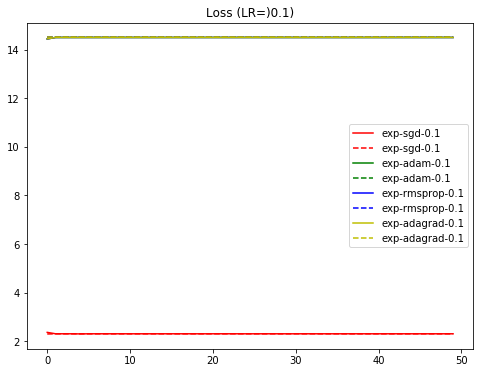

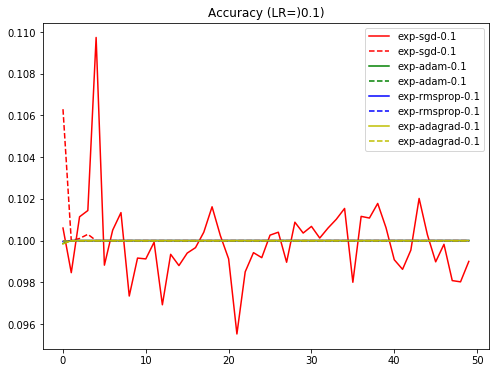

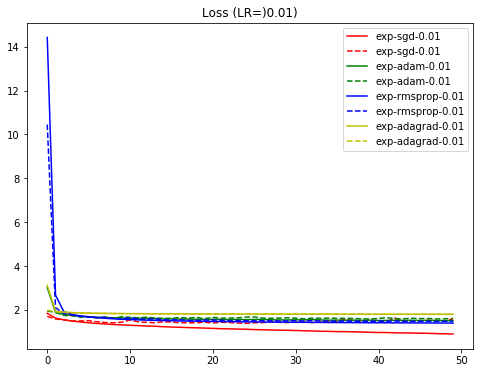

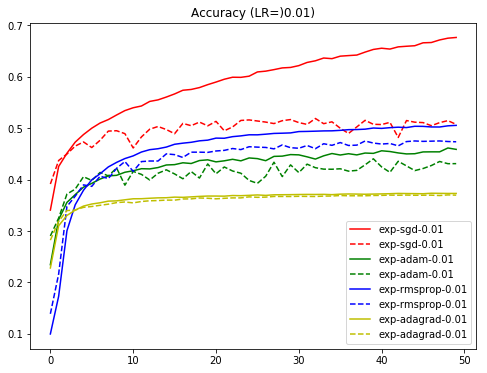

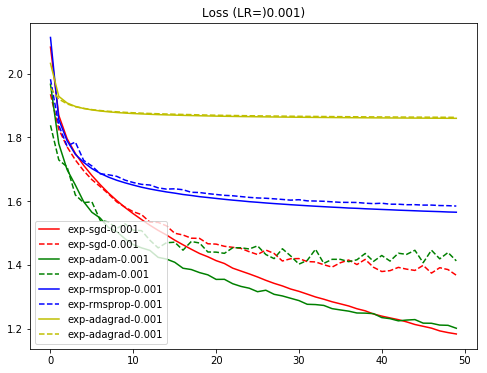

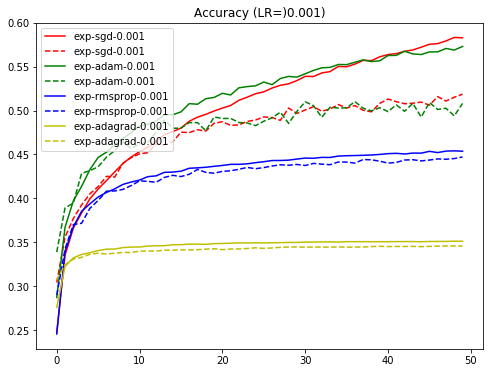

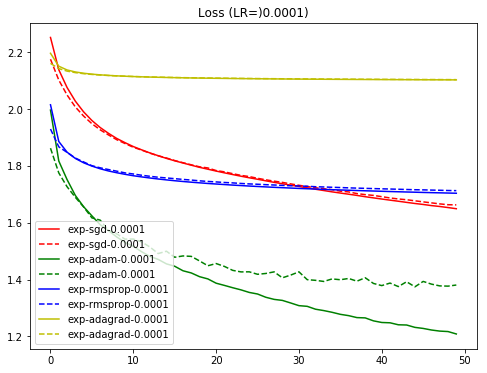

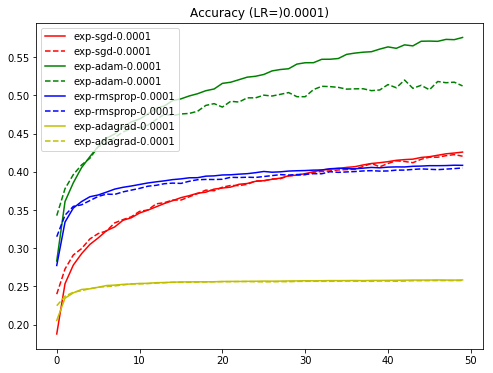

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

for lr in LEARNING_RATES:
    plt.figure(figsize=(8,6))
    for  i, optimizer in enumerate(['sgd','adam','rmsprop','adagrad']):
        key = 'exp-'+optimizer+'-'+str(lr)
        plt.plot(range(len(results[key]['train-loss'])),results[key]['train-loss'], '-', label=key, color=color_bar[i])
        plt.plot(range(len(results[key]['valid-loss'])),results[key]['valid-loss'], '--', label=key, color=color_bar[i])
    plt.title("Loss (LR=)"+str(lr)+")")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, optimizer in enumerate(['sgd','adam','rmsprop','adagrad']):
        key = 'exp-'+optimizer+'-'+str(lr)
        plt.plot(range(len(results[key]['train-acc'])),results[key]['train-acc'], '-', label=key, color=color_bar[i])
        plt.plot(range(len(results[key]['valid-acc'])),results[key]['valid-acc'], '--', label=key, color=color_bar[i])
    plt.title("Accuracy (LR=)"+str(lr)+")")
    plt.legend()
    plt.show()

### Answer

從結果來看，LR相對小的時候（0.001､0.0001）收斂較慢
最佳結果出現在LR=0.01､optimizer為SGD時
執行次數epochs = 50後
訓練集準確率0.68、測試集準確率0.5